In [5]:
import tensorflow as tf
import os
import numpy as np
import re
from PIL import Image
import matplotlib.pyplot as plt

images/1348715451683.jpg


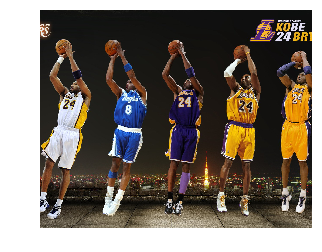

basketball (score = 0.31505)
cornet, horn, trumpet, trump (score = 0.20611)
trombone (score = 0.07039)
French horn, horn (score = 0.06895)
torch (score = 0.05404)

images/1352111852802.jpg


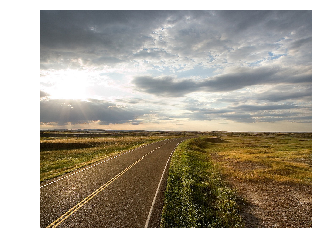

valley, vale (score = 0.10700)
seashore, coast, seacoast, sea-coast (score = 0.08045)
radio telescope, radio reflector (score = 0.06110)
worm fence, snake fence, snake-rail fence, Virginia fence (score = 0.04574)
hay (score = 0.03486)

images/2013031210463.jpg


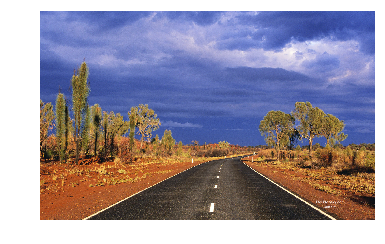

trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi (score = 0.13544)
alp (score = 0.08559)
worm fence, snake fence, snake-rail fence, Virginia fence (score = 0.04421)
rapeseed (score = 0.03720)
lakeside, lakeshore (score = 0.03202)

images/716270269729589177.jpg


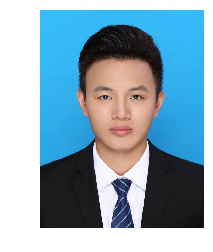

suit, suit of clothes (score = 0.54435)
Windsor tie (score = 0.22287)
groom, bridegroom (score = 0.02144)
notebook, notebook computer (score = 0.00822)
bow tie, bow-tie, bowtie (score = 0.00708)

images/car.jpg


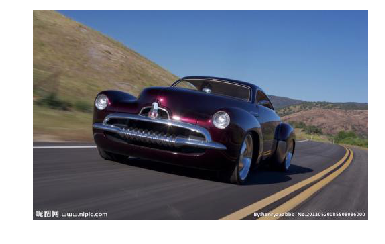

sports car, sport car (score = 0.35468)
convertible (score = 0.18448)
grille, radiator grille (score = 0.10041)
car wheel (score = 0.06035)
racer, race car, racing car (score = 0.01784)

images/cat.jpg


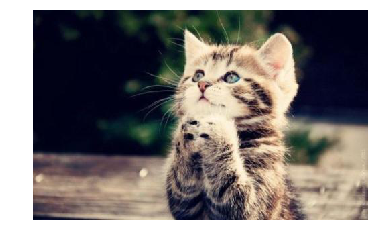

Egyptian cat (score = 0.52724)
tabby, tabby cat (score = 0.31426)
tiger cat (score = 0.05848)
lynx, catamount (score = 0.01089)
meerkat, mierkat (score = 0.00966)

images/dog.jpg


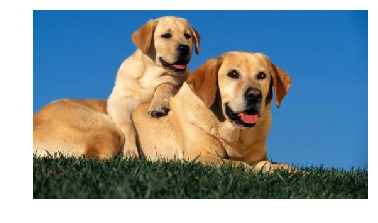

Labrador retriever (score = 0.96095)
golden retriever (score = 0.01103)
Rhodesian ridgeback (score = 0.00212)
English foxhound (score = 0.00140)
Greater Swiss Mountain dog (score = 0.00059)

images/ed9e31809f83b044916deb9430fcce7c.jpg


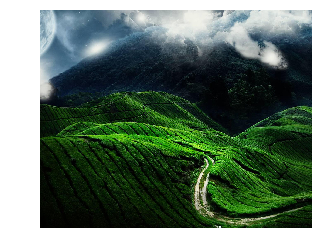

knot (score = 0.21307)
valley, vale (score = 0.16018)
alp (score = 0.05402)
green snake, grass snake (score = 0.04317)
volcano (score = 0.03842)

images/plane.jpg


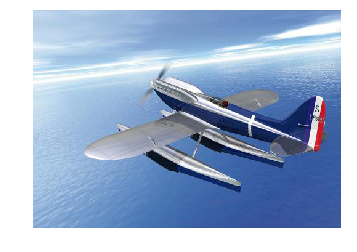

warplane, military plane (score = 0.36024)
wing (score = 0.09475)
airliner (score = 0.07708)
projectile, missile (score = 0.03622)
space shuttle (score = 0.03241)

images/seaside.jpg


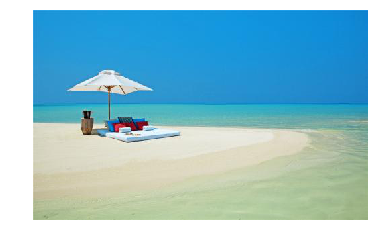

sandbar, sand bar (score = 0.97875)
seashore, coast, seacoast, sea-coast (score = 0.00552)
umbrella (score = 0.00247)
catamaran (score = 0.00220)
speedboat (score = 0.00052)



In [ ]:
class NodeLookup(object):
    def __init__(self):  
        label_lookup_path = 'inception_model/imagenet_2012_challenge_label_map_proto.pbtxt'   
        uid_lookup_path = 'inception_model/imagenet_synset_to_human_label_map.txt'
        self.node_lookup = self.load(label_lookup_path, uid_lookup_path)

    def load(self, label_lookup_path, uid_lookup_path):
        # 加载分类字符串n********对应分类名称的文件
        proto_as_ascii_lines = tf.gfile.GFile(uid_lookup_path).readlines()
        uid_to_human = {}     #定义了一个空的字典
        #一行一行读取数据
        for line in proto_as_ascii_lines :
            #去掉换行符
            line=line.strip('\n')
            #按照'\t'(tab键)分割
            parsed_items = line.split('\t')
            #获取分类编号
            uid = parsed_items[0]
            #获取分类名称
            human_string = parsed_items[1]
            #保存编号字符串n********与分类名称映射关系
            uid_to_human[uid] = human_string   #类似于字典里的key（分类编号）-value（分类名称）关系

        # 加载分类字符串n********对应分类编号1-1000的文件
        proto_as_ascii = tf.gfile.GFile(label_lookup_path).readlines()
        node_id_to_uid = {}                                  #定义空字典
        for line in proto_as_ascii:
            if line.startswith('  target_class:'):           #搜索文件中类似于 target_class: 465 这样的行
                #获取分类编号1-1000
                target_class = int(line.split(': ')[1])  #"line.split(': ')"是以': '来切分；取分类后的[1]部分存放在target_class，总共就是分类编号1-1000
            if line.startswith('  target_class_string:'):    #搜索文件中类似于 target_class_string: "n01682714" 这样的行
                #获取编号字符串n********
                target_class_string = line.split(': ')[1] #同上，先切分，再咬冒号空格之后的第一个部分，存放在target_class_string
                #保存分类编号1-1000与编号字符串n********映射关系
                node_id_to_uid[target_class] = target_class_string[1:-2]#字典里key对应的value是取编号字符串"n01685808"的n01685808（1到倒数第二个，不要引号）
                #映射到字典里，key(分类编号)-value(分类编号字符串)
                #这里key就是target_class；value就是 target_class_string；

        #建立分类编号1-1000对应分类名称的映射关系 就是将上述两个字典合在一起
        node_id_to_name = {}
        for key, val in node_id_to_uid.items():
            #获取分类名称
            name = uid_to_human[val]
            #建立分类编号1-1000到分类名称的映射关系
            node_id_to_name[key] = name  #这里的key是node_id_to_uid.items()这个字典里的key,现在作为新的字典 node_id_to_name的key；
                                         #并将uid_to_human[val] 这个字典里的value定义为name也就是新的字典node_id_to_name的value
        return node_id_to_name

    #传入分类编号1-1000返回分类名称    这段是联系上下代码的关键
    def id_to_string(self, node_id):
        if node_id not in self.node_lookup:
            return ''
        return self.node_lookup[node_id]
        #注意整个程序前面的空格，不同空格，不同嵌套关系。
        #解释这段代码：开头有这行：self.node_lookup = self.load(label_lookup_path, uid_lookup_path)
        #第二段有这行： def load(self, label_lookup_path, uid_lookup_path)；这行的最终目的是将label_lookup_path和 uid_lookup_path中的key/value
        #最终合在一个字典里，实现key(分类编号1-1000)到value(分类名称)的字典映射关系。

#创建一个图来存放google训练好的模型
with tf.gfile.FastGFile('inception_model/classify_image_graph_def.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')


with tf.Session() as sess:
    softmax_tensor = sess.graph.get_tensor_by_name('softmax:0')
    #遍历目录
    for root,dirs,files in os.walk('images/'):
        for file in files:
            #载入图片
            image_data = tf.gfile.FastGFile(os.path.join(root,file), 'rb').read()
            predictions = sess.run(softmax_tensor,{'DecodeJpeg/contents:0': image_data})#图片格式是jpg格式
            predictions = np.squeeze(predictions)#把结果从2维转为1维数据，inception网络最后一层是softmax,将1000个结果用softmax转化为概率

            #打印图片路径及名称
            image_path = os.path.join(root,file)
            print(image_path)
            #显示图片
            img=Image.open(image_path)
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            #排序
            top_k = predictions.argsort()[-5:][::-1]    #排序，概率由小-大排序；取倒数5个，再对这5个值进行倒叙。就是大到小5个值
            node_lookup = NodeLookup()  #将前面定义的类实现
            for node_id in top_k:     
                #获取分类名称
                human_string = node_lookup.id_to_string(node_id)
                #获取该分类的置信度，就是分类的百分比，判断这个图片是狗、猫等的概率
                score = predictions[node_id]
                print('%s (score = %.5f)' % (human_string, score))
            print()